In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split('_')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+'_t.png')
        maskNames.append(unames[i]+'_i2.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

framObjTrain = LoadData( framObjTrain, imgPath = 'D:/Terrain Mapping/terrain maps'
                        , maskPath = 'D:/Terrain Mapping/segementation maps'
                         , shape = 128)

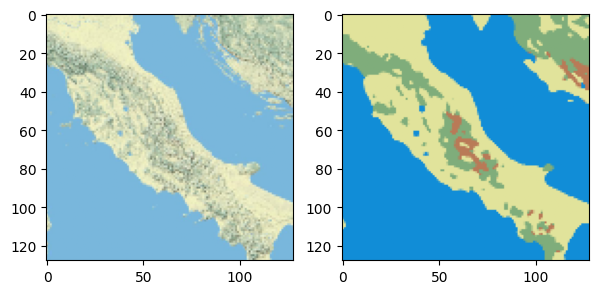

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (7, 5))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [ ]:

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

# Define the U-Net
def GiveMeUnet(inputImage, numFilters=16, droupouts=0.1, doBatchNorm=True):
    # Encoder
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize=3, doBatchNorm=doBatchNorm)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(numFilters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputImage], outputs=[output])
    return model

# Define the discriminator
def BuildDiscriminator(inputImage, numFilters=64, doBatchNorm=True):
    x = inputImage
    
    # Downsampling layers
    for _ in range(4):
        x = tf.keras.layers.Conv2D(numFilters, (4, 4), strides=(2, 2), padding='same')(x)
        if doBatchNorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    # Output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    discriminator = tf.keras.Model(inputs=[inputImage], outputs=[x])
    return discriminator

# Define the GAN model
def BuildGAN(generator, discriminator, inputImage, numFilters=16):
    # Make the discriminator non-trainable
    discriminator.trainable = False
    
    # Generate images from the generator
    generatedImage = generator(inputImage)
    
    # Get the discriminator's prediction for the generated images
    ganOutput = discriminator(generatedImage)
    
    # Create the GAN model
    gan = tf.keras.Model(inputs=[inputImage], outputs=[generatedImage, ganOutput])
    
    return gan

# Define the generator (U-Net)
inputShape = (256, 256, 3)
inputImage = tf.keras.layers.Input(shape=inputShape)
generator = GiveMeUnet(inputImage, droupouts=0.7)

# Build the discriminator
discriminator = BuildDiscriminator(inputImage)

# Build the GAN
gan = BuildGAN(generator, discriminator, inputImage)

# Define custom loss functions for generator and discriminator
def generator_loss(fake_output):
    return tf.keras.losses.mean_squared_error(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.mean_squared_error(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.mean_squared_error(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Compile the discriminator and GAN models (separately)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=discriminator_loss, metrics=['accuracy'])
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=[generator_loss, discriminator_loss], loss_weights=[1, 1])

# Training loop
def train_gan(generator, discriminator, gan, dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            # Train the discriminator
            real_images = batch
            fake_images = generator.predict(real_images)
            real_labels = np.ones((real_images.shape[0], 1))
            fake_labels = np.zeros((fake_images.shape[0], 1))

            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

            # Train the generator (via the GAN)
            gan_labels = np.ones((real_images.shape[0], 1))
            g_loss = gan.train_on_batch(real_images, [real_images, gan_labels])

        print(f"Epoch {epoch}/{epochs}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss[0]}")

# Prepare your data as a TensorFlow Dataset
# For example, assuming you have your data in numpy arrays img_data and mask_data:
dataset = tf.data.Dataset.from_tensor_slices((img_data, mask_data)).batch(batch_size)

# Train the GAN
train_gan(generator, discriminator, gan, dataset, epochs=50)

# Print model summaries
generator.summary()
discriminator.summary()
gan.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs=50, verbose=0)

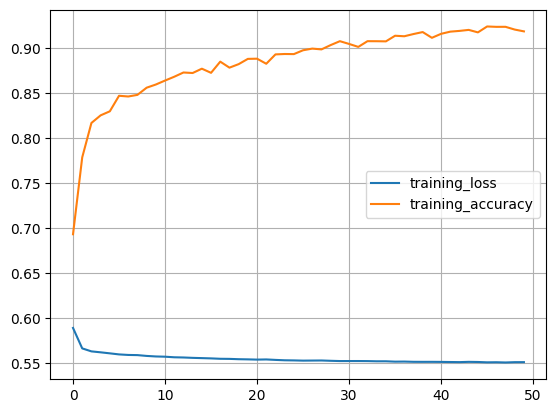

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Terrain Image')
    
    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mapped Terrain')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Sattelite Terrain')

125/125 [==============================] - 3s 20ms/step


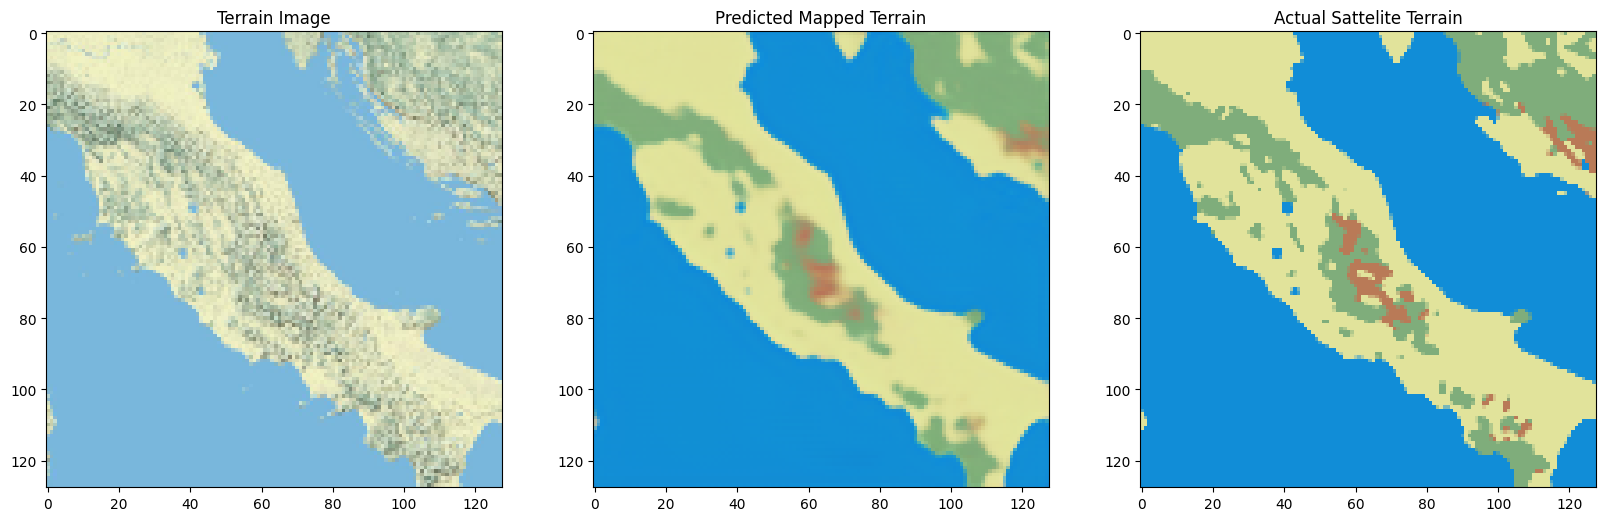

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1], masks[1])

In [ ]:
import os
import matplotlib.pyplot as plt

# Assuming 'output_folder' is the folder where you want to save the generated images.
output_folder = 'C:/Users/KIIT/OneDrive/Desktop/SIH/images'

# Make sure the output folder exists, create it if it doesn't.
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Your code to generate the predictions, actuals, and masks goes here.
# Assuming 'sixteenPrediction', 'actuals', and 'masks' are already defined.

# Replace this with your actual code to generate the image and the plot.
# You should have a figure or image variable containing the generated image.
# For example:
# figure = plt.figure()

# Plotter code here (assuming 'figure' contains the generated image):
# Plotter(actuals[1], sixteenPrediction[1], masks[1])

# Save the generated image to the specified folder.
image_filename = os.path.join(output_folder, 'generated_image.png')
# You can change the format (e.g., '.png', '.jpg', etc.) as needed.
plt.savefig(image_filename)

# Finally, if you want to display the image, you can use plt.show().
# plt.show()

# Close the plot (if you displayed it with plt.show()).
# plt.close()


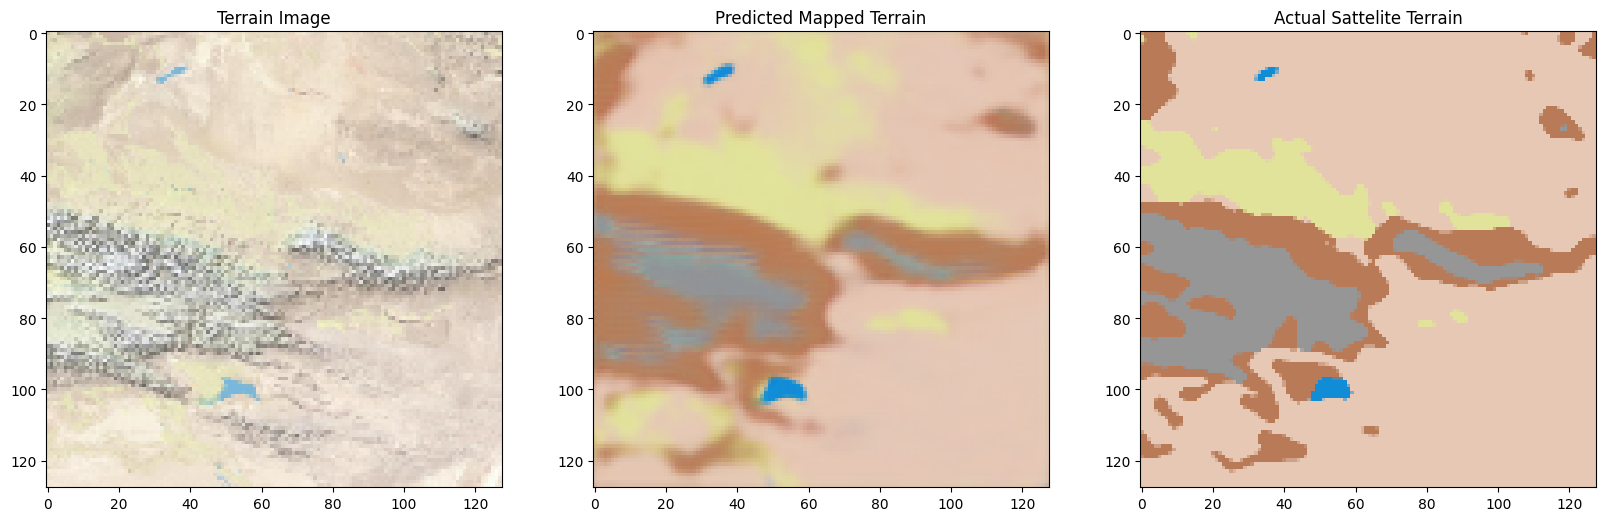

In [ ]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

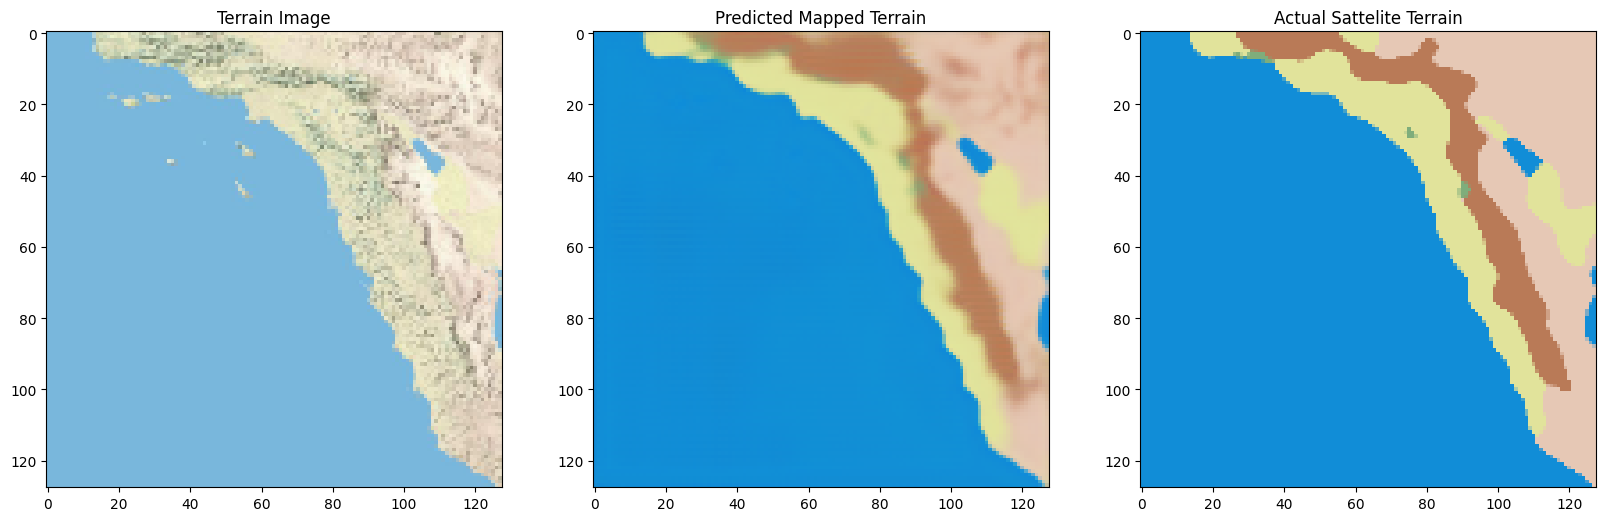

In [ ]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

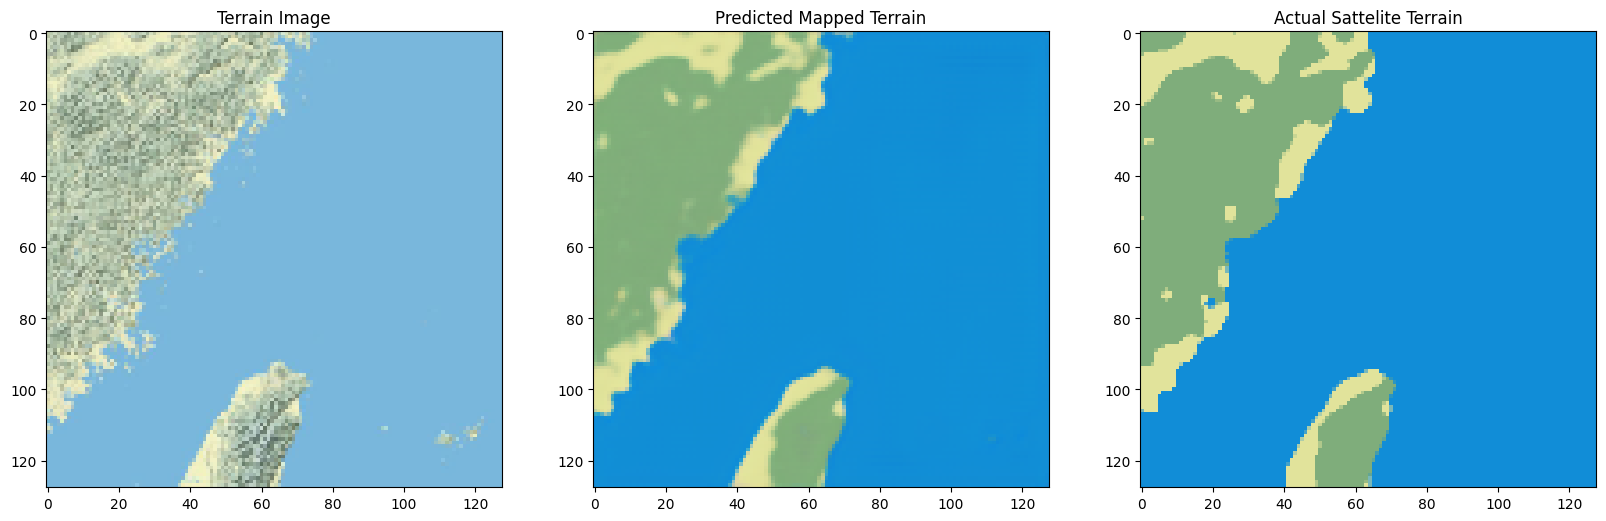

In [ ]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

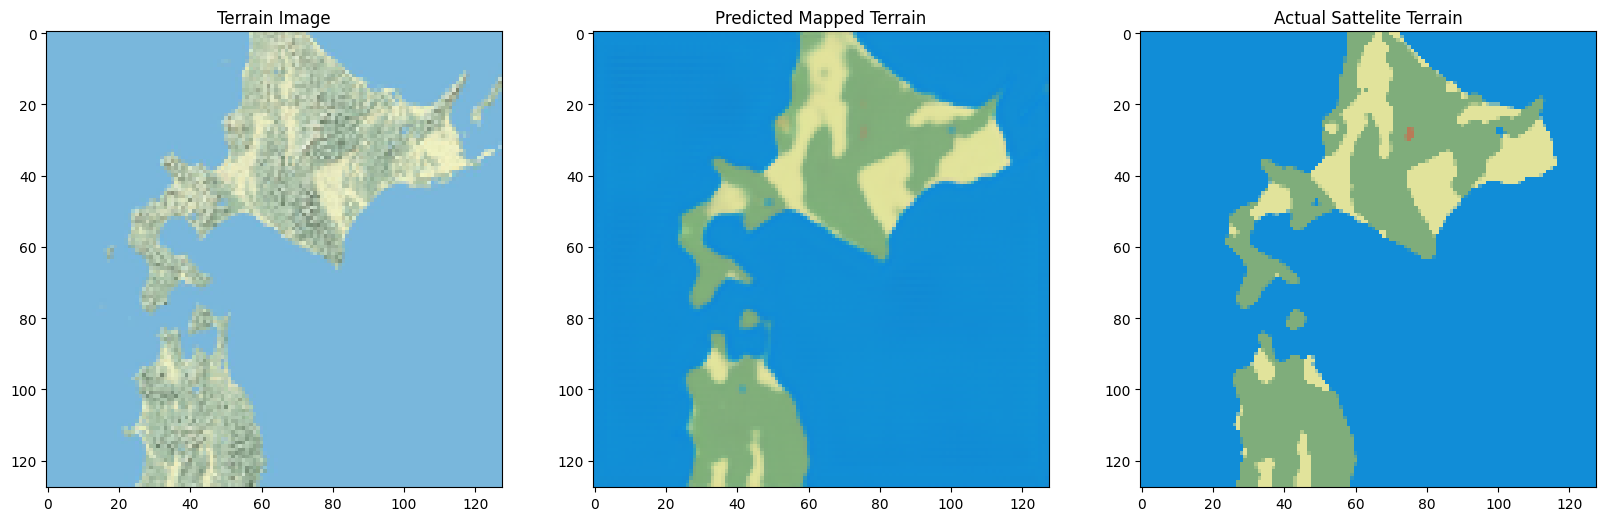

In [ ]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

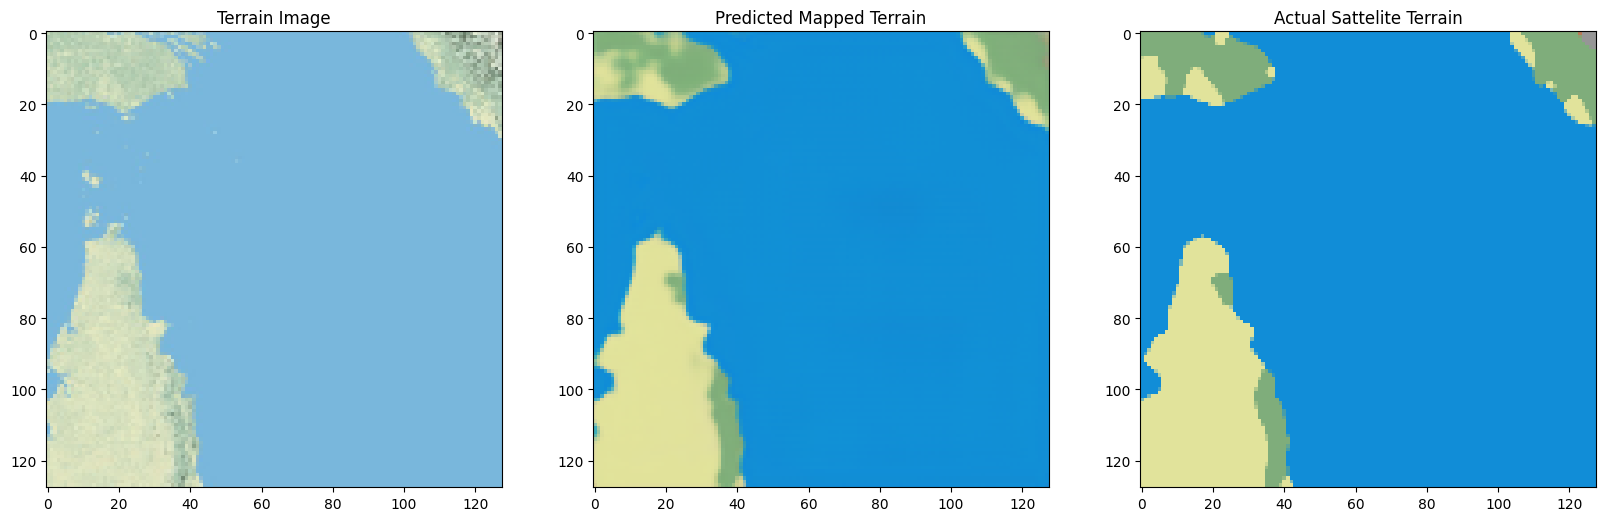

In [ ]:
Plotter(actuals[6], sixteenPrediction[6], masks[6])

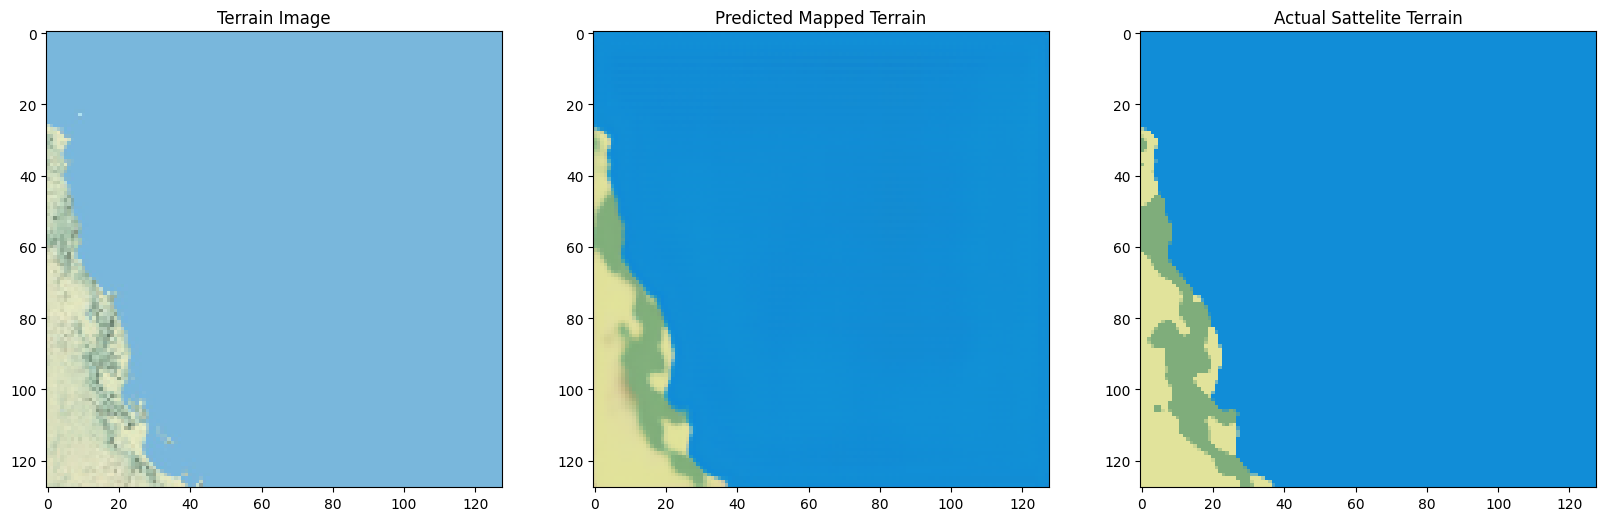

In [ ]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

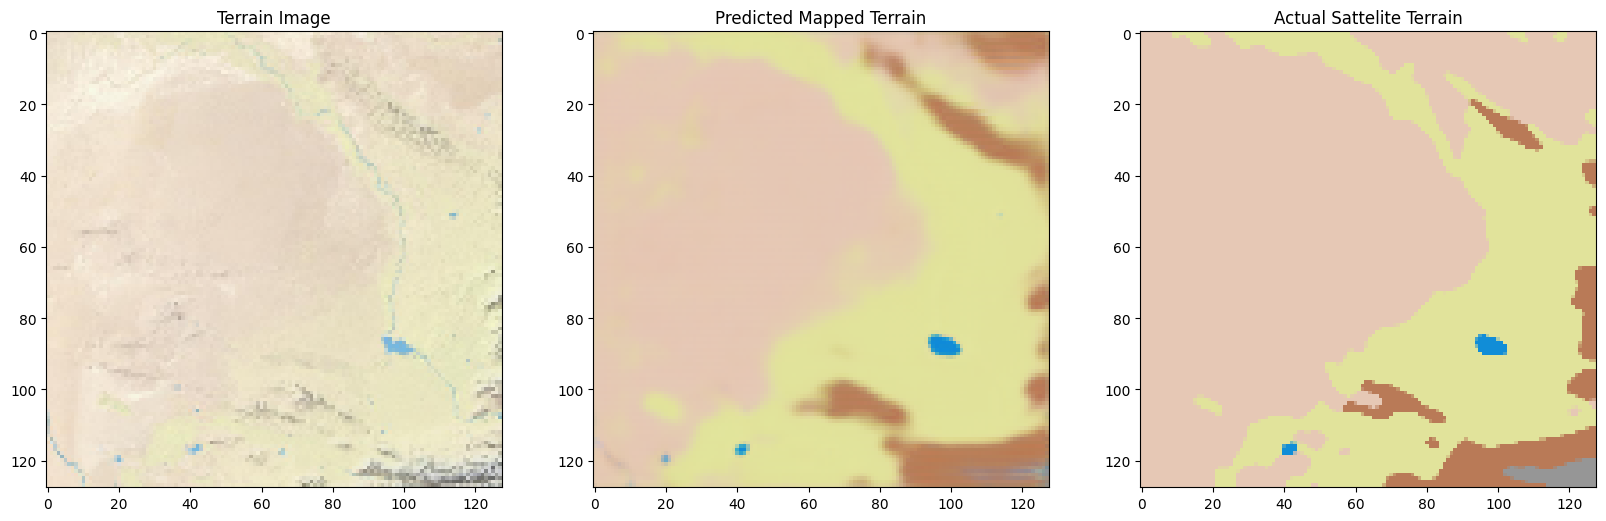

In [ ]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])

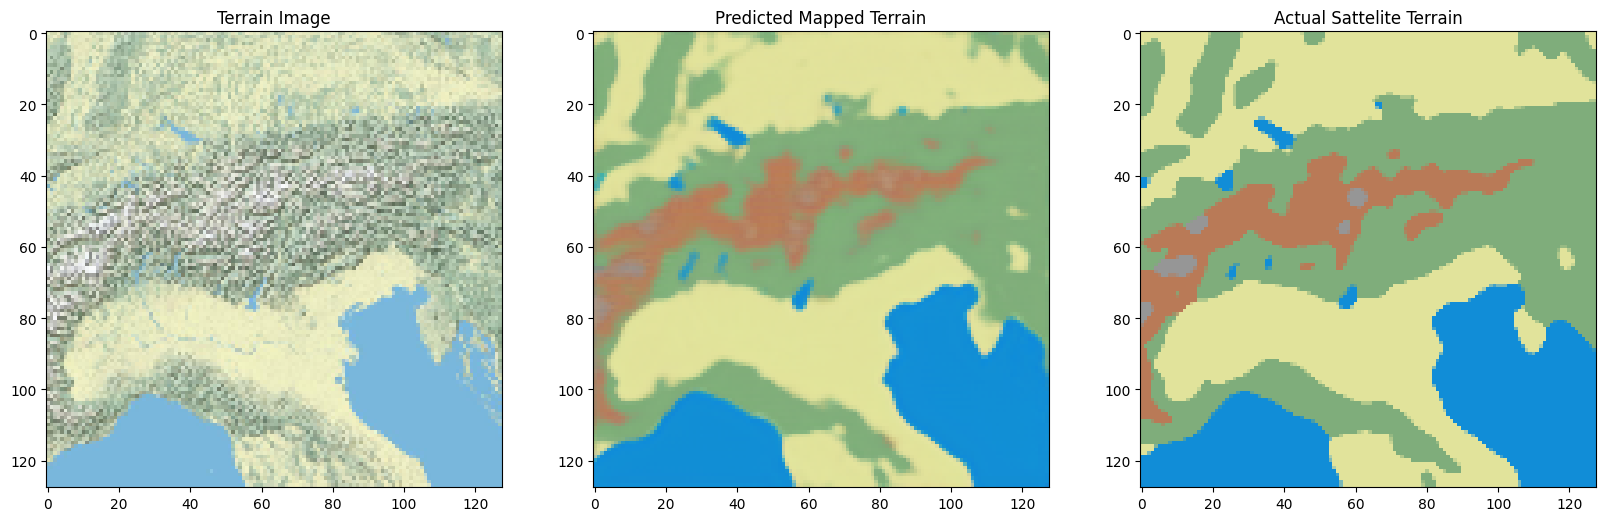

In [ ]:
Plotter(actuals[10], sixteenPrediction[10], masks[10])

In [ ]:
myTransformer.save('TerrainMaskGenerator.h5')